# 今日知识点预报
- mnist
- softmax
- 逻辑回归是怎么到bp的
- bp框架


# MNIST介绍
ref: https://zhuanlan.zhihu.com/p/264960142 <br>
首先下载mnist数据集<br>
http://yann.lecun.com/exdb/mnist/



# 数据加载和预处理

In [96]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd 
import math

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)


def load_labels(file):
    '''
    解码标签文件
    '''
    with open(file, "rb") as f:
        data = f.read()  # kp: 任务整理 readlines  readline  and read 的区别
    
    magic_number, num_samples = struct.unpack(">ii", data[:8])  # refer to magic_number.jpg  # struct.unpack refer to https://docs.python.org/3/library/struct.html
                                                                # >ii refer to https://docs.python.org/3/library/struct.html
    if magic_number != 2049:
        print(f"magic number mismatch {magic_number} != 2049")
        return None

    labels = np.array(list(data[8:])) # np.asarray  
    return labels
""" 
稍稍了解一下
大端字节序和小端字节序
big-endian and little-endian
 """

def load_images(file):
    with open(file, "rb") as f: # note rb or r
        data = f.read()
    
    magic_number, num_samples, image_height, image_width = struct.unpack(">iiii", data[:16])

    if magic_number != 2051:
        print(f"magic number mismatch {magic_number} != 2051")
        return None
    
    image_data = np.array(list(data[16:]), dtype=np.uint8).reshape(num_samples, -1) # dtype = "uint8"

    return image_data



train_labels = load_labels("dataset/train-labels-idx1-ubyte")
train_images = load_images("dataset/train-images-idx3-ubyte")
train_numdata = train_labels.shape[0] # 60000
train_pd = pd.DataFrame(train_labels, columns = ["label"])

val_labels = load_labels("dataset/t10k-labels-idx1-ubyte") # 10000
val_images = load_images("dataset/t10k-images-idx3-ubyte") # 10000, 784
val_numdata = val_labels.shape[0]    # 10000

## 可视化数据 和 数据分析

In [97]:
# idx = 19
# plt.imshow(train_images[idx][:-1].reshape(28,28)) # 可视化第五张图片来看看
# _ = plt.title(f"label = {train_labels[idx]}")

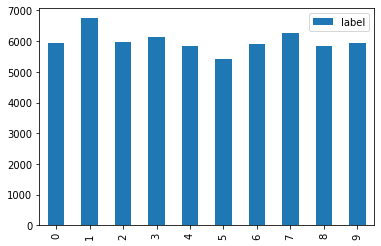

In [98]:
# np.ones((4,4), dtype = np.uint8)
# np.ones((4,4), dtype = np.float32)
# np.ones((4,4), dtype = np.float64) # 默认 64 
# np.ones((4,4), dtype = "float32")
# np.ones((4,4), dtype = "float64")

def one_hot(labels, classes):
    n = len(labels)
    output = np.zeros((n, classes), dtype = np.int32)
    for row, label in enumerate(labels):
        output[row, label] = 1
    return output

# one_hot(val_labels,10)

def show_hist(labels, num_classes): # 常用的小工具函数的写法
    label_map = {key: 0 for key in range(num_classes)} # 给每一个类都初始化： 数量为0
    for label in labels:       # 循环labels，遇到label x  就去label x的keyvalue对里+1
        label_map[label] += 1  # 这里相当于是一个一个label item去算
    
    # label_hist 是一个list, list 的值是 label_map key-value 对儿里的 value
    labels_hist = [label_map[key] for key in range(num_classes)]  
    pd.DataFrame(labels_hist, columns=["label"]).plot(kind = "bar") # api 用法的形象记忆 refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
                                                                    # refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
show_hist(train_labels, 10)


In [99]:
train_pd.describe()

,label
count,60000.000000
mean,4.453933
std,2.889270
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [100]:
train_pd.value_counts()


label
1        6742
7        6265
3        6131
2        5958
9        5949
0        5923
6        5918
8        5851
4        5842
5        5421
dtype: int64

train_labels

In [101]:
train_numdata, val_numdata

(60000, 10000)

# 创建管理数据和数据加载的类
回顾一下我们线性回归和逻辑回归，我们是怎么做数据管理的
我们其实并没有做, 为什么？
<br>因为数据量少
<br>现在我们跟原来相比，我们训练集有60000张图片，任何东西一多了，我们就要管理，所以我们要搞一些类对数据进行管理
<br>我们提出了三个类，分别是
<br>class Dataset &nbsp;&nbsp; class DataLoader  &nbsp;&nbsp;  class DataLoaderIterator
<br>为什么呢？先形象理解一下 

- 查看 manage_dataset.jpg
- 涉及到的知识点

    - 有__iter__和__next__  iterator   iterable
    - Iterable : 只要对象实现了__iter__ 就是可迭代对象     但是有时候依然无法迭代，因为实际iterable 仅仅是提供了一种抽象规范的接口  （简化代码等作用）
    - Iterator:    迭代器肯定是iterable 的     但是iterable 不一定是iterator。只有实现了__next__ 和__iterable__的才是迭代器。(不严谨地说，也就是可以被for循环了)。换句话说： 要想被for loop 必须实现__next__  和__iterable__
	
    
- 严谨地说法是：
	要想for .. in ..某个类实例
	- 1.要么直接在这个类下直接实现__iter__ 和__next__
	- 2.要么只实现__iter__ ，但是__iter__ 返回的的对象实现了__next__

- 注意__getitem__ 属于__iter__ 和__next__的高级封装

In [102]:
class Dataset:
    # 动态的，那么Dataset是个基类，所有动态的继承自Dataset
    # 需要实现什么接口？
    def __getitem__(self, index):
        raise NotImplementedError()
        
    def __len__(self):
        raise NotImplementedError()
    

class MNIST_Dataset(Dataset):
    # 针对mnist数据的解析、加载、预处理(e.g. /255 - 0.5), 加一个全是1的维度etc
    def __init__(self, image_file, label_file):
        self.num_classes = 10
        self.images = load_images(image_file)
        self.labels = load_labels(label_file)

        # self.images = np.hstack((self.images / 255.0, np.ones((len(self.images), 1)))).astype(np.float32)
        self.images = (self.images / 255.0).astype(np.float32)
        self.labels_one_hot = one_hot(self.labels, self.num_classes)
        
    def __getitem__(self, index):
        """ 
        角色的职责
        实现图像加载、归一化/标准化、onehot
            为什么要返回one_hot，计算时，使用one_hot比较方便
            为什么要返回label，因为做测试的时候，label比较方便
            pytorch里面，CELoss使用的不是one_hot。所以以后不需要返回one_hot
         """
        return self.images[index], self.labels[index], self.labels_one_hot[index]

    # 获取数据集的长度，个数
    def __len__(self):
        return len(self.images)

In [103]:
class DataLoader:
    """
    职责
    实例化的时候需要指定dataset，batch_size，shuffle
    数据的封装，打包为一个batch
    对数据进行打乱
    可以通过迭代器来获取一批一批的数据
     """
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.shuffle = shuffle
        self.count_data = len(dataset)
        self.batch_size = batch_size

    def __iter__(self):
        # 实例化一个迭代器对象，将自身作为参数传入进去
        return DataLoaderIterator(self)

    def __len__(self):
        """ 
        用以告诉外界，多少次迭代，就算是完成一轮
        这里有2种处理方法
        1.向上取整
        2.整除，向下取整，多余部分丢弃
        这里考虑用策略2
         """
        return len(self.dataset) // self.batch_size
        

class DataLoaderIterator:
    """ 
    职责：
        对打包好的batch一个一个的输出
     """
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
        # 这里有2中处理策略
        # 1.向上取整
        # 2.整除，向下取整，多余部分丢弃
        # 这里考虑用方法2
        self.num_batch_per_epoch = len(dataloader)
        
        # 定义指针记录当前batch的索引
        self.batch_cursor = 0

        # 实现一轮数据的打乱和封装获取
        # 与其打乱数据，不如打乱索引
        self.indexes = list(range(len(dataloader.dataset)))

        # 如果需要随机打乱，条件控制由dataloader的shuffle决定
        if dataloader.shuffle:
            np.random.shuffle(self.indexes)  # inplace e.g. [0,1,2,3 ....59999] --> [2,1,48,23,...0]

    
    def __next__(self): # 指的是next batch
        # 如果到了一轮的边界，即迭代结束，抛出异常 (一上来就做判断)
        if self.batch_cursor >= self.num_batch_per_epoch:
            # 如果到了边界，抛出StopIteration
            raise StopIteration()
        """ 
        职责：如何一个又一个的数据进行吐出, 每一行是一个数据
            b1  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b2  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b3  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            ......
            n 个 data
        
        images.shape = n x 784     labels.shape = n x 1        one_hot.shape = n x 10
         """ 

        batch_data = []
        for i in range(self.dataloader.batch_size): # 遍历一个batch里的图片
            """ 
             拿到图像的索引，这个索引可能是打乱的
              """
            index = self.indexes[self.batch_cursor * self.dataloader.batch_size + i] # 全局idx
            
            # 从dataset中拿到数据 e.g. 一个数据由图像和标签组成
            data_item = self.dataloader.dataset[index]

            if len(batch_data) == 0:
                batch_data = [[] for _ in data_item] # 这里有3个
            
            # 把data_item中的每一项，分门别类的放到batch_data中
            for index, item in enumerate(data_item):
                batch_data[index].append(item)


        # 遍历完了这个batch里的所有图片，要到下一个batch了
        self.batch_cursor += 1

        # 当整个batch的数据准备好过后，可以用np.vstack拼接在一起
        for index in range(len(batch_data)):
            batch_data[index] = np.vstack(batch_data[index])

        return tuple(batch_data)



## 各种init， 数据加载 和 数据预处理 权重初始化

In [113]:
# 初始化权重，和定义网络
np.random.seed(3)
num_train_images = train_images.shape[0]
num_feature = train_images.shape[1]
num_hidden = 256
num_classes = 10
batch_size = 32
lr = 0.1
num_epochs = 30

# 加载数据
train_dataset = MNIST_Dataset("dataset/train-images-idx3-ubyte", "dataset/train-labels-idx1-ubyte")
train_loader  = DataLoader(train_dataset, batch_size, True)
test_dataset = MNIST_Dataset("dataset/t10k-images-idx3-ubyte", "dataset/t10k-labels-idx1-ubyte")
test_loader  = DataLoader(test_dataset, 512, True)


# 初始化权重
W = np.random.normal(0, 1, size = (num_feature, num_classes)) # (785, 10)
W[:,-1] = 0.0
b = -1
# W


In [114]:
for epoch in range(num_epochs):
    for images, _, one_hot_labels in train_loader:
        # print(images.shape, labels.shape, one_hots.shape)
        # break
        predict = images @ W + b
        probability = softmax(predict)

        # loss = -np.sum(one_hot_labels * np.log(probability) + (1 - one_hot_labels) * np.log(1 - probability)) / batch_size
        loss = -np.sum(one_hot_labels * np.log(probability)) / batch_size

        G = (probability - one_hot_labels) / batch_size

        # matrix multiplication
        del_W = images.T @ G
        del_b = np.sum(G)
        
        W -= lr * del_W
        b -= lr * del_b


    # 每一个epoch 验证一次
    correct = 0
    for test_images, test_labels, test_one_hot_labels in test_loader:
        predict = test_images @ W + b
        predict_labels     = predict.argmax(axis=1).reshape(-1, 1)
        
        correct          += (predict_labels == test_labels).sum()
    
    acc = correct / len(test_dataset)
    print(f"{epoch}. train_Loss: {loss:.3f}, test_Accuracy: {acc:.5f}")
    


0. train_Loss: 0.847, test_Accuracy: 0.82370
1. train_Loss: 0.750, test_Accuracy: 0.83960
2. train_Loss: 0.722, test_Accuracy: 0.85580
3. train_Loss: 0.085, test_Accuracy: 0.85730
4. train_Loss: 0.603, test_Accuracy: 0.86430
5. train_Loss: 0.405, test_Accuracy: 0.86700
6. train_Loss: 0.179, test_Accuracy: 0.86920
7. train_Loss: 0.576, test_Accuracy: 0.87400
8. train_Loss: 0.642, test_Accuracy: 0.87370
9. train_Loss: 0.205, test_Accuracy: 0.87270
10. train_Loss: 0.995, test_Accuracy: 0.87590
11. train_Loss: 0.323, test_Accuracy: 0.87590
12. train_Loss: 0.084, test_Accuracy: 0.87970
13. train_Loss: 0.718, test_Accuracy: 0.87920
14. train_Loss: 0.060, test_Accuracy: 0.88290
15. train_Loss: 0.564, test_Accuracy: 0.88210
16. train_Loss: 0.158, test_Accuracy: 0.88080
17. train_Loss: 0.123, test_Accuracy: 0.88260
18. train_Loss: 0.090, test_Accuracy: 0.88140
19. train_Loss: 0.351, test_Accuracy: 0.88370
20. train_Loss: 0.478, test_Accuracy: 0.88500
21. train_Loss: 0.209, test_Accuracy: 0.8865